In [19]:
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
def generate_low_rank_samples(d1,d2,K,n): 

    res = np.zeros((d1,d2))
    for k in range(K):
        u = np.random.rand(d1,1)
        v = np.random.rand(d2,1)
        res += 1/K * u.dot(v.T)
    P = res/np.sum(res)
    p = np.reshape(P,d1*d2)
    X  = np.random.multinomial(n,p)
    Y1 = np.reshape(X,(d1,d2))
    X  = np.random.multinomial(n,p)
    Y2 = np.reshape(X,(d1,d2))
    
    return(res,Y1/n, Y2/n)



def generate_dirichlet_low_rank_samples(d1,d2,K,n,diric1,diric2): 
    
    res = np.zeros((d1,d2))
    for k in range(K):
        u = np.random.dirichlet(diric1*np.ones(d1),1)
        v = np.random.dirichlet(diric2*np.ones(d2),1)
        res += 1/K * u.T.dot(v)
    p = np.reshape(res,d1*d2)
    X  = np.random.multinomial(n,p)
    Y1 = np.reshape(X,(d1,d2))
    X  = np.random.multinomial(n,p)
    Y2 = np.reshape(X,(d1,d2))
    
    return(res,Y1/n, Y2/n)



Les fonctions generate_dirichlet_low_rank_samples et generate_low_rank_samples sont deux manières différentes de générer la matrice de proba $P$ et les matrices d'observations $Y_1/n$ et $Y_2/n$. 


In [20]:
def our_algo(n,Y1,Y2,alpha,cstar,Cbar):
    (d1,d2) = np.shape(Y1)
    d = max(d1,d2)
    
    if (n <= d*np.log(d)):
        return((Y1+Y2)/2)
      
    else:
        res = np.zeros((d1,d2))
        T = int(np.log(d)/np.log(2))
        p = np.sum(Y1, axis=1)
        q = np.sum(Y1, axis=0)
        
        for t in range(T+1):
            if (t<T):
                I = np.argwhere((p <= 2**(-t)) & (p > 2**(-t-1)))
            else: 
                I = np.argwhere((p <= 2**(-t)))
                
            for u in range(T+1):
                if (u<T):
                    J = np.argwhere((q <= 2**(-u)) & (q > 2**(-u-1)))
                else: 
                    J = np.argwhere(q <= 2**(-u))
                #M = np.zeros(np.shape(Y2))  
                M = np.zeros((len(I),len(J)))
                
                for i in range(len(I)):
                    for j in range(len(J)):
                        M[i,j] = Y2[I[i],J[j]]
                
                if (np.sum(M) < 2*Cbar*alpha*np.log(d)/(n*np.log(2))):
                    for i in range(len(I)):
                        for j in range(len(J)):
                            res[I[i],J[j]] = Y2[I[i],J[j]]
                else:
                    #print((t,u))
                    tau = np.log(d) * np.sqrt(cstar * 2**(1-min(t,u))/n)
                    U,s,Vh = np.linalg.svd(M)
                    l = len(s[s>=tau])
                    #l = 5
                    H = np.dot(U[:,:l]*s[:l], Vh[:l,:])
                    for i in range(len(I)):
                        for j in range(len(J)):
                            res[I[i],J[j]] = H[i,j]
        return(res/np.sum(res))

In [27]:
K = 10
Cbar = .5
alpha = .1
cstar= alpha/10
beg = 100
end = 400
step = 20
error_low_rank  = np.zeros(len(range(beg,end,step)))
error_empirical = np.zeros(len(range(beg,end,step)))

for (i,d) in enumerate(range(beg,end,step)):
    d1 = d
    d2 = d
    n = int(10000*d*np.log(d)**2)
    diric1 = d1/(3*K)
    diric2 = d2/(3*K)
    (P,Y1,Y2) = generate_dirichlet_low_rank_samples(d1,d2,K,n, diric1,diric2)
    #(P,Y1,Y2) = generate_low_rank_samples(d1,d2,K,n, diric1,diric2)
    P_hat = our_algo(n,Y1,Y2,alpha,cstar,Cbar)
    error_low_rank[i] = np.sum(np.abs(P-P_hat))
    error_empirical[i] = np.sum(np.abs(P-Y2))


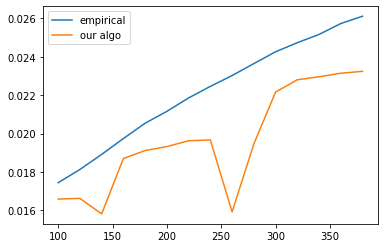

In [31]:
plt.plot(range(beg,end,step), error_empirical, label='empirical')
plt.plot(range(beg,end,step), error_low_rank, label = 'our algo')
plt.legend(loc="upper left")
plt.show()